In [2]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy import spatial
import xarray as xr

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [4]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

In [28]:
# to do: select only the applicable date from L4 
#    and try restrict lats and lons of l2 dataset

l4 = xr.open_dataset('../Data/cci_sst.nc')
l4 = l4.sel(time=slice('2008-12-18','2008-12-24'))

l2_list = glob.glob('../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_200903*.nc')
l3_list = glob.glob('../Data/TSST/ESA_CCI_L3U_AATSR_200812*.nc')

'''
https://data-dive.com/interactive-large-data-plots-datashader
'''

# l2 = xr.open_dataset('../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081218.nc')
# l2 = xr.open_mfdataset(glob.glob('../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_200812*.nc'))

# l3 = xr.open_dataset('../Data/TSST/ESA_CCI_L3U_AATSR_20081218.nc')

'\nhttps://data-dive.com/interactive-large-data-plots-datashader\n'

In [39]:
# l4['analysis_uncertainty'][1]['time'].data
l2_list

['../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081218.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081220.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081219.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081221.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081222.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081223.nc',
 '../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081224.nc']

In [30]:
tester = xr.open_dataset('../Data/TSST/ESA_CCI_L2P_AVHRRMTA_G_20081218.nc')

In [6]:
tester

<xarray.Dataset>
Dimensions:             (num_observations: 5145424)
Dimensions without coordinates: num_observations
Data variables:
    latitude            (num_observations) float32 ...
    longitude           (num_observations) float32 ...
    along_track_SST     (num_observations) float32 ...
    standard_deviation  (num_observations) float32 ...
    hour                (num_observations) float32 ...
    minute              (num_observations) float32 ...
    second              (num_observations) float32 ...
Attributes:
    title:         Processed along-track ESA CCI L2P SST data from AVHRRMTA_G...
    source:        ESA CCI SST http://data.ceda.ac.uk/neodc/esacci/sst
    references:    https://github.com/sanAkel/Harry_uCapeTown/tree/master/ESA...
    date_created:  Year 2020

In [35]:
# tester_subset = tester.where(tester['latitude'] <= -10)
tester_subset = tester.where((tester['latitude'] <= -10) & (tester['latitude'] >= -50))
tester_subset = tester_subset.where((tester_subset['longitude'] <= 70) & (tester_subset['longitude'] >= 0))
tester_subset_arr = tester_subset.to_array()
tester_subset_arr = np.delete(tester_subset_arr, np.where(tester_subset_arr[1] == np.nan))

ValueError: dimensions ('variable', 'num_observations') must have the same length as the number of data dimensions, ndim=1

In [39]:
tester_subset_arr = tester_subset_arr[1][tester_subset_arr[1] != np.nan]

In [41]:
tester_subset_arr.shape

(5145424,)

In [33]:
tester_subset_arr

<xarray.DataArray (variable: 7, num_observations: 5145424)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * variable  (variable) <U18 'latitude' 'longitude' ... 'minute' 'second'
Dimensions without coordinates: num_observations
Attributes:
    title:         Processed along-track ESA CCI L2P SST data from AVHRRMTA_G...
    source:        ESA CCI SST http://data.ceda.ac.uk/neodc/esacci/sst
    references:    https://github.com/sanAkel/Harry_uCapeTown/tree/master/ESA...
    date_created:  Year 2020

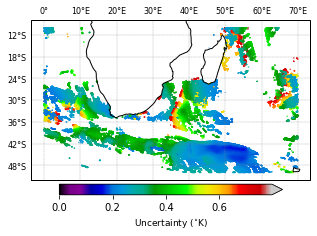

<Figure size 432x288 with 0 Axes>

In [12]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(tester_subset['longitude'], tester_subset['latitude'], s=0.05, c=tester_subset['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), vmin=0)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Uncertainty ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

In [11]:
# l2_sel = l2.where(l2['latitude'] <= -10 and l2['latitude'] >= -50)
l2_sel = l2.where(l2['latitude'] <= -10)
l2_sel = l2.where(l2['latitude'] >= -50)
# l2.where(l2['latitude'].isin([-50, -10]), drop=True)

In [29]:
l2_sel = l2.where((l2['latitude'] <= -10) & (l2['latitude'] >= -50))
l2_sel = l2_sel.where((l2_sel['longitude'] <= 70) & (l2_sel['longitude'] >= 0))
l2_sel_arr = l2_sel.to_array()
# l2_sel = np.delete(l2_sel.to_array(), np.where(l2_sel['latitude'] == np.nan))

In [43]:
l2_sel_arr = np.delete(l2_sel_arr[1,], np.where(l2_sel_arr[1,] == np.nan))
# l2_sel_arr[1,]

In [44]:
l2_sel_arr

<xarray.DataArray (num_observations: 4436979)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    variable  <U18 'longitude'
Dimensions without coordinates: num_observations

In [12]:
l2_sel['latitude'].data.shape

(4436979,)

In [13]:
l2

<xarray.Dataset>
Dimensions:             (num_observations: 4436979)
Dimensions without coordinates: num_observations
Data variables:
    latitude            (num_observations) float32 63.367184 ... 69.004875
    longitude           (num_observations) float32 -19.831053 ... -53.650387
    along_track_SST     (num_observations) float32 ...
    standard_deviation  (num_observations) float32 ...
    hour                (num_observations) float32 ...
    minute              (num_observations) float32 ...
    second              (num_observations) float32 ...
Attributes:
    title:         Processed along-track ESA CCI L2P SST data from AVHRRMTA_G...
    source:        ESA CCI SST http://data.ceda.ac.uk/neodc/esacci/sst
    references:    https://github.com/sanAkel/Harry_uCapeTown/tree/master/ESA...
    date_created:  Year 2020

# Plot along-track point obs

## L2

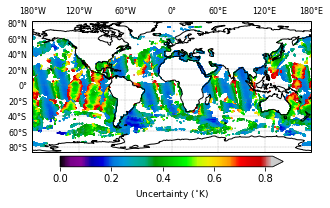

<Figure size 432x288 with 0 Axes>

In [7]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l2['longitude'], l2['latitude'], s=0.05, c=l2['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), vmin=0)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Uncertainty ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## L3

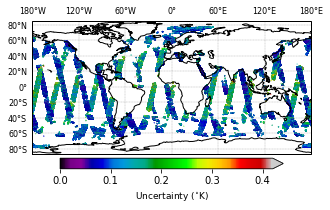

<Figure size 432x288 with 0 Axes>

In [6]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l3['longitude'], l3['latitude'], s=0.05, c=l3['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), vmin=0)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Uncertainty ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

# Plot errors without differences

## L4

In [21]:
l4['analysed_sst'][1]

<xarray.DataArray 'analysed_sst' (lat: 800, lon: 1200)>
[960000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -49.975 -49.925 -49.875 ... -10.125 -10.075 -10.025
  * lon      (lon) float32 0.025 0.075 0.125 0.175 ... 59.875 59.925 59.975
    time     datetime64[ns] 2008-12-19T12:00:00
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_water_temperature
    units:          kelvin
    valid_min:      -300
    valid_max:      4500
    source:         ATSR<1,2>-ESACCI-L3U-v2.0, AATSR-ESACCI-L3U-v2.0, AVHRR<0...

0
1
2
3
4
5
6


/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


[]

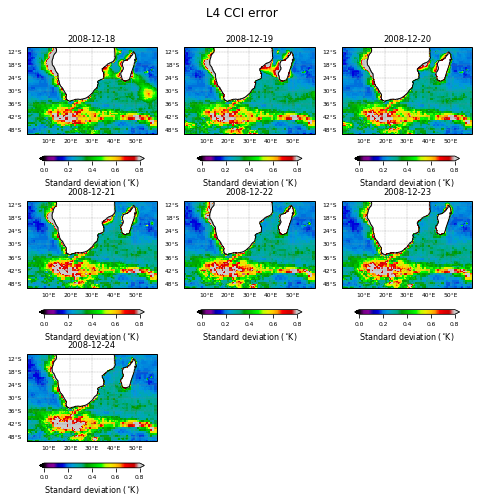

In [23]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
fig.suptitle('L4 CCI error', y=0.95)

for i in range(0,7):
    print(i)
    
    ax = plt.subplot(3,3,i+1,projection=proj)
    ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())
    
    img = l4['analysis_uncertainty'][i].plot(transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=0.8)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.17)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Standard deviation ($^{\circ}$K)', fontsize=8)

    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    ax.set_title('{0}'.format(l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')), fontsize='small')

plt.tight_layout(h_pad=1.0)
plt.savefig('../Figures/error_differences/L4_error.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()

## L2

0
1
2
3
4
5
6


/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


[]

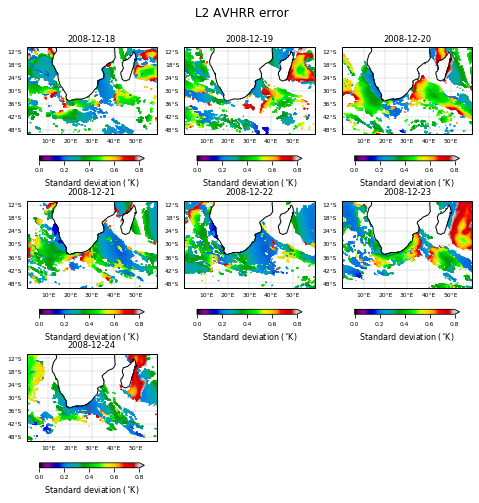

In [29]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
fig.suptitle('L2 AVHRR error', y=0.95)

for i in range(0,7):
    print(i)
    
    l2_dataset = xr.open_dataset(l2_list[i])
    l2_dataset = l2_dataset.where((l2_dataset['latitude'] <= -10) & (l2_dataset['latitude'] >= -50))
    l2_dataset = l2_dataset.where((l2_dataset['longitude'] <= 70) & (l2_dataset['longitude'] >= 0))
        
    ax = plt.subplot(3,3,i+1,projection=proj)
    ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())
    
    img = plt.scatter(l2_dataset['longitude'], l2_dataset['latitude'], s=0.05, c=l2_dataset['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), vmin=0, vmax=0.8)
    cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.17)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Standard deviation ($^{\circ}$K)', fontsize=8)
    
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    ax.set_title('{0}'.format(l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')), fontsize='small')

plt.tight_layout(h_pad=1.0)
plt.savefig('../Figures/error_differences/L2_tracksAtSEN900Error.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()

## L3

0
1
2
3
4
5
6


/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


[]

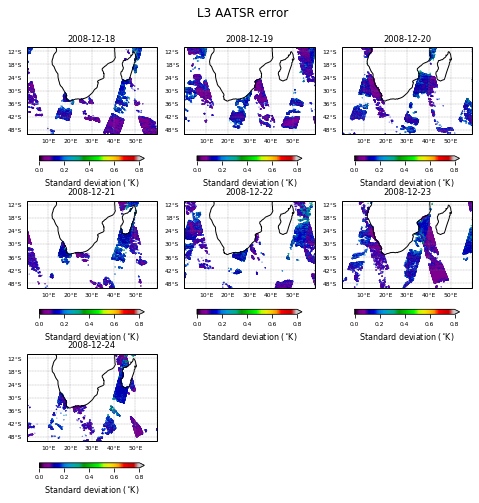

In [19]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
fig.suptitle('L3 AATSR error', y=0.95)

for i in range(0,7):
    print(i)
    
    l3_dataset = xr.open_dataset(l3_list[i])
    l3_dataset = l3_dataset.where((l3_dataset['latitude'] <= -10) & (l3_dataset['latitude'] >= -50))
    l3_dataset = l3_dataset.where((l3_dataset['longitude'] <= 70) & (l3_dataset['longitude'] >= 0))
        
    ax = plt.subplot(3,3,i+1,projection=proj)
    ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())
    
    img = plt.scatter(l3_dataset['longitude'], l3_dataset['latitude'], s=0.05, c=l3_dataset['standard_deviation'], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), vmin=0, vmax=0.8)
    cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.17)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Standard deviation ($^{\circ}$K)', fontsize=8)
    
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    ax.set_title('{0}'.format(l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')), fontsize='small')

plt.tight_layout(h_pad=1.0)
plt.savefig('../Figures/error_differences/L3_error.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()

# Define function for finding difference between point obs and nearest grid neighbour

In [24]:
def NearestNeighbourDiff(grid, points, gridInf=1, pointsInf=1):
    ''' The KDTree method used below is outlined at the link below:
       https://github.com/blaylockbk/pyBKB_v3/blob/master/demo/KDTree_nearest_neighbor.ipynb
    with some minor modifications in order to produce the differences.
    '''
    
    # Try find lon and lat variables for gridded dataset
    try:
        gridLons = grid['longitude']
    except KeyError:
        try:
            gridLons  = grid['lon']
        except KeyError:
            print("Can't detect gridded dataset longitude dimension.")
            
    try:
        gridLats = grid['latitude']
    except KeyError:
        try:
            gridLats  = grid['lat']
        except KeyError:
            print("Can't detect gridded dataset latitude dimension.")
    
    # Try find lon and lat variables for point observations dataset
    try:
        pointsLons = points['longitude']
    except KeyError:
        try:
            pointsLons  = points['lon']
        except KeyError:
            print("Can't detect point observations longitude dimension.")
            
    try:
        pointsLats = points['latitude']
    except KeyError:
        try:
            pointsLats  = points['lat']
        except KeyError:
            print("Can't detect point observations latitude dimension.")
    
    # Create meshgrid for use with KDTree
    x,y = np.meshgrid(*(gridLons, gridLats))
    
    # Build KDTree from L4 grid
    print('Now building KDTree...')
    tree = spatial.cKDTree(np.column_stack([x.ravel(), y.ravel()]))
    
    # Gather obs coordinates into a numpy column stack
    obs_points = np.column_stack([pointsLons, pointsLats])
    
    # Obtain distances between L2 obs and nearest L4 cell and the index of the L4 cell as
    #   recorded in the KDTree object (tree). Setting upper bound limits distances between
    #   L2 obs and L4 cells and will speed up the operation.
    print('Now querying KDTree for point observations...')
    dist, idx = tree.query(obs_points, distance_upper_bound=0.05, n_jobs=-1)
    print('Tree query completed.')
    
    # Squeeze L4 SSTs and then stack to obtain vector of temperatures to match shape of
    #   L2 observations for easy differencing
    grid_VecErrs = grid['analysis_uncertainty'].squeeze().stack(vec=['lon', 'lat'])
    
    # Obtain the difference between the L2 obs and the nearest L4 cell
    error_diff = (points['standard_deviation'] * pointsInf) - (grid_VecErrs[idx-1].data * gridInf)
    
    return error_diff, gridInf, pointsInf

# Plot differences between L4 and TSSTs

## L4 vs L2

0
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
1
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
2
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
3
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
4
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
5
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
6
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.


/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


[]

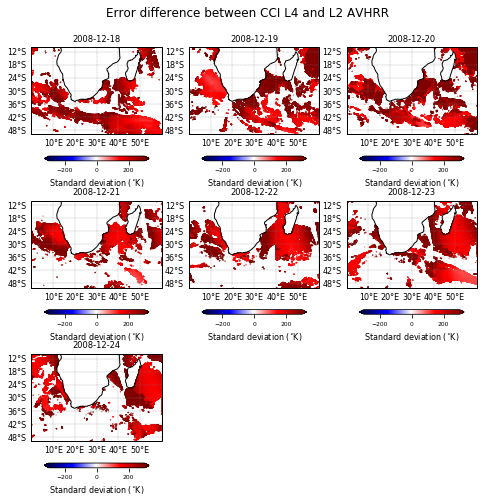

In [27]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
fig.suptitle('Error difference between CCI L4 and L2 AVHRR', y=0.95)

for i in range(0,7):
    print(i)
    
    l2_dataset = xr.open_dataset(l2_list[i])
    l2_dataset = l2_dataset.where((l2_dataset['latitude'] <= -10) & (l2_dataset['latitude'] >= -50))
    l2_dataset = l2_dataset.where((l2_dataset['longitude'] <= 70) & (l2_dataset['longitude'] >= 0))
    errDiff, gridInf, pointsInf = NearestNeighbourDiff(l4.isel(time=i), l2_dataset, gridInf=25, pointsInf=800)
    
    ax = plt.subplot(3,3,i+1,projection=proj)
    ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())
    
    img = plt.scatter(l2_dataset['longitude'], l2_dataset['latitude'], s=0.05, c=errDiff, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), vmin=-300, vmax=300)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.17)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Standard deviation ($^{\circ}$K)', fontsize=8)

    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.set_title('{0}'.format(l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')), fontsize='small')

plt.tight_layout(h_pad=1.0)
plt.savefig('../Figures/error_differences/L4_{0}_L2_{1}.png'.format(gridInf, pointsInf), dpi=300, bbox_inches='tight', format='png')
plt.plot()

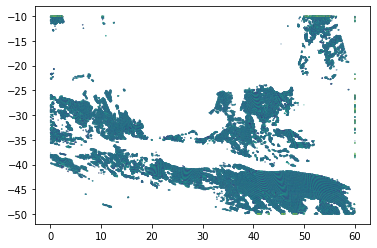

In [65]:
xs = tree.data[idx-1][:,0]
ys = tree.data[idx-1][:,1]
plt.scatter(xs, ys, s=0.05, c=dist)

## L4 vs L3

0
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
1
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
2
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
3
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
4
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
5
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.
6
Now building KDTree...
Now querying KDTree for point observations...
Tree query completed.


/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


[]

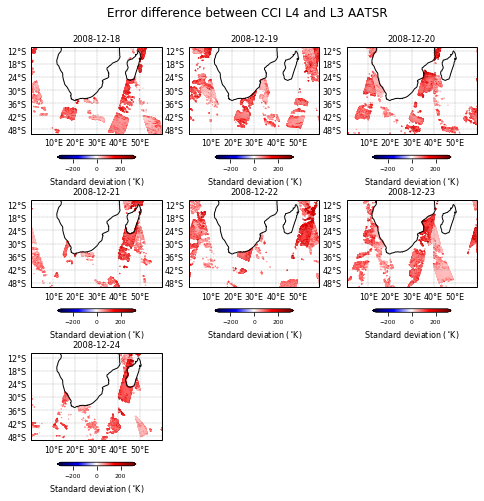

In [26]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8))
fig.suptitle('Error difference between CCI L4 and L3 AATSR', y=0.95)

for i in range(0,7):
    print(i)
    
    l3_dataset = xr.open_dataset(l3_list[i])
    l3_dataset = l3_dataset.where((l3_dataset['latitude'] <= -10) & (l3_dataset['latitude'] >= -50))
    l3_dataset = l3_dataset.where((l3_dataset['longitude'] <= 70) & (l3_dataset['longitude'] >= 0))
    errDiff, gridInf, pointsInf = NearestNeighbourDiff(l4.isel(time=i), l3_dataset, gridInf=25, pointsInf=800)
    
    ax = plt.subplot(3,3,i+1,projection=proj)
    ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())
    
    img = plt.scatter(l3_dataset['longitude'], l3_dataset['latitude'], s=0.05, c=errDiff, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), vmin=-300, vmax=300)
    cbar = plt.colorbar(img, shrink=0.6, extend='both', orientation='horizontal', pad=0.17)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label('Standard deviation ($^{\circ}$K)', fontsize=8)

    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.set_title('{0}'.format(l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')), fontsize='small')
    
plt.tight_layout(h_pad=1.0)
plt.savefig('../Figures/error_differences/L4_{0}_L3_{1}.png'.format(gridInf, pointsInf), dpi=300, bbox_inches='tight', format='png')
plt.plot()

In [35]:
plt.rcParams['axes.titlesize']

'large'

In [18]:
# l4['analysis_uncertainty'][i]['time'].data.split()[0]
l4['analysis_uncertainty'][i]['time'].data.astype('datetime64[D]')

numpy.datetime64('2009-12-18')

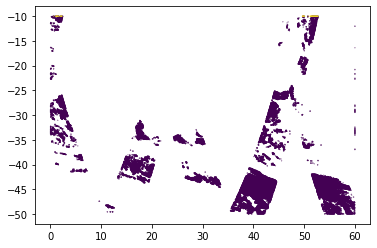

In [56]:
xs = tree.data[idx-1][:,0]
ys = tree.data[idx-1][:,1]
plt.scatter(xs, ys, s=0.05, c=dist)

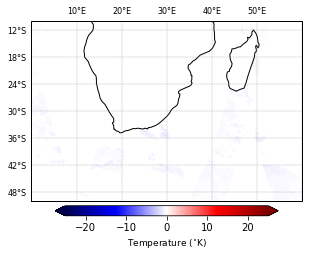

<Figure size 432x288 with 0 Axes>

In [69]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent([0, 60, -50, -10], ccrs.PlateCarree())

#gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
img = plt.scatter(l3['longitude'], l3['latitude'], s=0.05, c=error_diff_l3, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), vmin=-25, vmax=25)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Temperature ($^{\circ}$K)', fontsize=9)

ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()